<h1 style="text-align: center;"><b>Deep Learning Tutorial: Convolutional Neural Networks (CNNs)</b></h1>

**Class:** *3 DSAI*

**Pair:**
* [*BOUSSELAT Ahmed Moncef*](https://github.com/Somnef)
* [*KIMOUCHE Rayane*](https://github.com/RayaneKimo)

## **Intro**

In this practical tutorial, we will be constructing a convolutional neural network (CNN) capable of distinguishing between pictures of dogs and pictures of cats.

Convolutional neural networks are a type of neural network that aims to extract features from a signal (whether be it an image, a sound, or any other type of signal, but most commonly images) instead of treating them as raw arrays of data, it has been demonstrated to be more effective than the latter mentionned approach numerous times, as it hugely increases the effectiveness of a network related to its size.

The data we have chosen for this work is sourced from a [Kaggle dataset](https://www.kaggle.com/datasets/tongpython/cat-and-dog?fbclid=IwAR0k788XFiLpQAyETBnW-GzvL_Pyhk4pXhoiBHF_plC4_R_E6w9sv2BT3Bg) of 10032 pictures balanced between cats' and dogs' picutres. The data needs to be put in a folder under root called "data" with 2 subfolders: "training_set" and "test_set", each of them also containing 2 subfolders: "cats" and "dogs".

Our process consists of 7 main steps:

* [Setup](#setup): Import libraries
* [Data preparation](#data_prep): Load and prepare (transform) the data
* [Model definition](#model_def): Play around and construct an architecture we are satisfied with
* [Trainer definition](#trainer_def): Define a utility class that helps us do the training without messy code
* [Hyperparameters definition](#hp_def)
* [Training](#training)
* [Visual Test](#vis_test)

For this tutorial, we chose to use PyTorch as a deep learning framework.
<h5 style="color:orange">
    PS: If you're executing this in colab, you should choose a GPU runtime for the training to occur faster.
</h5>

<a id='setup'></a>
## **Setup**
Here we import the necessary packages and select the right device following the machine at hand.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms as tr

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

<a id='data_prep'></a>
## **Data preparation**
In this step, we define the transforms to apply to the data, which essentially consist of resizing the images, normalizing them around their mean and standard deviation, and also making them square by cropping from the center. At some point, we tried adding guassian noise to the training data, but it wasn't positive for the efficiency of the model.

We also put the target variable (cat: 0, dog: 1) in a tensor because it starts off in an int.

<h4 style="color:orange">
    PS: Uncomment the following cell if data is not already setup (it will require that you upload your <b>kaggle.json</b> key to the current directory).
</h4>

In [ ]:
# Uncomment this cell if data is not already setup

# %pip install -q kaggle

# !rm -rf data sample_data

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d tongpython/cat-and-dog
# !unzip -q cat-and-dog.zip

# !rm -rf cat-and-dog.zip

# !mkdir -p data
# !mv test_set/test_set data
# !mv training_set/training_set data

# !rm -rf training_set test_set

In [3]:
# Custom target transform that puts the target, which is initially an int, in a tensor
class IntToTensor:
    def __call__(self, number):
        return torch.tensor([number])
    
    def __repr__(self):
        return self.__class__.__name__


# Define the transforms (size is the size to which the images are reduced)
size = 256
train_transform = tr.transforms.Compose([
    tr.ToTensor(),
    tr.Resize(size=size),
    tr.CenterCrop(size=size),
    tr.Normalize(mean=[0.4909, 0.4555, 0.4172], std=[0.2604, 0.2530, 0.2550]), # We manually computed mean and std from the training dataset beforehand
])

test_transform = tr.transforms.Compose([
    tr.ToTensor(),
    tr.Resize(size=size),
    tr.CenterCrop(size=size),
    tr.Normalize(mean=[0.4909, 0.4555, 0.4172], std=[0.2604, 0.2530, 0.2550]), # We manually computed mean and std from the training dataset beforehand
])

target_transform = tr.transforms.Compose([
    IntToTensor(),
])

# Create the training and testing datasets with the associated transforms
train_dataset = datasets.ImageFolder('data/training_set', transform=train_transform, target_transform=target_transform)
test_dataset = datasets.ImageFolder('data/test_set/', transform=test_transform, target_transform=target_transform)

# Make train and test loaders that shuffle and query images in batches with the sizes we define
train_batch_size = 30
test_batch_size = 60

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

<a id='model_def'></a>
## **Model definition**
In this step, we define out Convolutional Neural Network (CNN), we find that 3 convolutional layers (each with a convolution initialized with a Xavier transform, and then put through a relu, and then a maxpooling layer), which then feed into 3 fully connected layers gives relatively good results.

The following image illustrates our architecture:

<img src="./architecture.PNG" alt="Architecture" width="600" class="center"/>

<style>
    .center {
        display: block;
        margin-left: auto;
        margin-right: auto;
    }
</style>

In [5]:
class CNN(torch.nn.Module):
    def __init__(self, img_size):
        super().__init__()

        # This part serves as an initialization so that the model can take on any size of images as long as it's square
        self.img_size = img_size

        ff1_input_size = img_size
        
        ff1_input_size -= 2
        ff1_input_size = np.floor(ff1_input_size / 2)
        ff1_input_size -= 2
        ff1_input_size = np.floor(ff1_input_size / 2)
        ff1_input_size -= 2
        ff1_input_size = np.floor(ff1_input_size / 2)

        ff1_input_size *= ff1_input_size * 30

        ff2_input_size = np.floor(np.sqrt(ff1_input_size))
        ff3_input_size = np.floor(np.sqrt(ff2_input_size))

        ff1_input_size = int(ff1_input_size)
        ff2_input_size = int(ff2_input_size)
        ff3_input_size = int(ff3_input_size)

        # 1st Convolution + Maxpool
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)

        # 2nd Convolution + Maxpool
        self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

        # 3rd Convolution + Maxpool
        self.conv3 = torch.nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.relu3 = torch.nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2)

        # Flatten everything except
        self.flatten = torch.nn.Flatten(1)

        # 1st Feedforward layer
        self.ff1 = torch.nn.Linear(in_features=ff1_input_size, out_features=ff2_input_size)
        torch.nn.init.xavier_uniform_(self.ff1.weight)
        self.sigmoid1 = torch.nn.Sigmoid()

        # 2nd Feedforward layer
        self.ff2 = torch.nn.Linear(in_features=ff2_input_size, out_features=ff3_input_size)
        torch.nn.init.xavier_uniform_(self.ff2.weight)
        self.sigmoid2 = torch.nn.Sigmoid()

        # 3rd Feedforward layer
        self.ff3 = torch.nn.Linear(in_features=ff3_input_size, out_features=1)
        torch.nn.init.xavier_uniform_(self.ff3.weight)
        self.sigmoid3 = torch.nn.Sigmoid()


    def forward(self, x):
        if len(x.shape) != 4 or x.shape[1] != 3 or x.shape[2:] != (self.img_size, self.img_size):
            print(f"ERROR: Input must be of shape (batch_size, 3, {self.img_size}, {self.img_size}")
            return None

        out = x

        out = self.conv1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        out = self.conv3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)

        out = self.flatten(out)

        out = self.ff1(out)
        out = self.sigmoid1(out)

        out = self.ff2(out)
        out = self.sigmoid2(out)

        out = self.ff3(out)
        out = self.sigmoid3(out)

        return out


    def name(self):
        return 'CNN'

    def save(self, path):
        torch.save(self.state_dict(), path)


model = CNN(img_size=size).to(device)

<a id='trainer_def'></a>
## **Trainer definition**
Instead of having messy training code, we wrote a wrapper class which defines all of the necessary modular functionalities that the training and testing may need. This way, later on, we are able to train and test our model with just one line of code, which also makes it easier to work with when doing gridsearch on hyperparameters and similar operations.

In [6]:
class ModelTrainer:
    # This function initializes the trainer
    def __init__(self, model, optimizer, loss_fn, train_loader, test_loader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn

        self.train_loader = train_loader
        self.test_loader = test_loader

        self.train_losses = {}
        self.test_losses = {}

        self.train_accuracies = {}
        self.test_accuracies = {}
        
        self.current_training_epoch = 0


    # This is the main function to call outside of the class to train the model for the number of epochs wanted
    def train(self, nb_epochs, test_every_epoch=True, logs_interval_percentage=None):
        if logs_interval_percentage is not None:
            print(f"{'*'*12} CURRENT MODEL ({self.current_training_epoch} epochs trained) {'*'*12}")

            train_loss, train_accu = self.test(on_test_set=False)
            print(f"Avg. train loss = {train_loss:.5f}")
            print(f"Avg. train accuracy = {(train_accu*100):.2f}%\n")

            test_loss, test_accu = self.test()
            print(f"Avg. test loss = {test_loss:.5f}")
            print(f"Avg. test accuracy = {(test_accu*100):.2f}%")
            
            print(f"{'*'*60}")

        for epoch in range(nb_epochs):
            print(f"{'*'*20} TRAINING EPOCH #{self.current_training_epoch+1} {'*'*20}")
            
            epoch_loss, epoch_accu = self.train_one_epoch(logs_interval_percentage)

            print(f"\nAvg. epoch training loss = {epoch_loss:.5f}")
            print(f"Avg. epoch training accuracy = {(epoch_accu*100):.2f}%\n")

            if test_every_epoch:
                epoch_test_loss, epoch_test_accu = self.test()
                print(f"Avg. epoch test loss = {epoch_test_loss:.5f}")
                print(f"Avg. epoch test accuracy = {(epoch_test_accu*100):.2f}%")

            print(f"{'*'*61}")

        print(f"{'*'*22} END OF TRAINING {'*'*22}")
        print(f"{'*'*61}")


    # This function does the training of the model for ONE epoch
    def train_one_epoch(self, logs_interval_percentage=None):
        next_log_p = logs_interval_percentage

        batch_losses = []
        batch_accuracies = []
        for i, (x, y) in enumerate(self.train_loader):
            x, y = x.to(self.device).float(), y.to(self.device).float()

            batch_loss, batch_accuracy = self.train_step(x, y)
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_accuracy)

            if logs_interval_percentage is None or next_log_p is None:
                continue

            p = (i+1) / len(self.train_loader)
            if p > next_log_p or i == 0 or p == 1: 
                print(f"Batch #{str(i+1).zfill(len(str(len(self.train_loader))))} ({str(int(np.round(p*100))).rjust(3)}%):\tloss = {batch_loss:.5f}\taccuracy = {(batch_accuracy*100):.2f}%")
                if i != 0 and p != 1:
                    next_log_p += logs_interval_percentage

        self.current_training_epoch += 1
        
        epoch_loss = np.mean(batch_losses)
        epoch_accu = np.mean(batch_accuracies)
        self.train_losses[self.current_training_epoch] = epoch_loss
        self.train_accuracies[self.current_training_epoch] = epoch_accu

        return epoch_loss, epoch_accu


    # This function is meant to be called inside train_one_epoch() to do the training step per say (gradient computation and back prop)
    def train_step(self, x, y):
        self.model.train()

        y_hat = self.model(x)

        loss = self.loss_fn(y_hat, y)
        loss.backward()

        accu = (torch.round(y_hat) == y).cpu().sum() / len(x)

        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item(), accu


    # This function computes the loss and accuracy of the model on a given dataset (test or train, following the 
    # param on_test_set) without affecting the weights in any way
    def test(self, on_test_set=True):
        self.model.eval()

        batch_losses = []
        batch_accuracies = []

        with torch.no_grad():
            loader = self.test_loader if on_test_set else self.train_loader
            for x, y in loader:
                x, y = x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)

                batch_loss = self.loss_fn(y_hat, y).item()
                batch_losses.append(batch_loss)

                batch_accuracy = (torch.round(y_hat) == y).cpu().sum() / len(x)
                batch_accuracies.append(batch_accuracy)

        loss = np.mean(batch_losses)
        accu = np.mean(batch_accuracies)

        if on_test_set:
            self.test_losses[self.current_training_epoch] = loss
            self.test_accuracies[self.current_training_epoch] = accu
        else:
            self.train_losses[self.current_training_epoch] = loss
            self.train_accuracies[self.current_training_epoch] = accu


        return loss, accu


    # This is a utility function to change the optimizer at any point
    def setOptimizer(self, optimizer):
        self.optimizer = optimizer

    # This is a utility function to change the loss function at any point
    def setLossFn(self, loss_fn):
        self.loss_fn = loss_fn


    # This is a utility function to change the train loader at any point
    def SetTrainLoader(self, train_loader):
        self.train_loader = train_loader


    # This is a utility function to change the test loader at any point
    def SetTestLoader(self, test_loader):
        self.test_loader = test_loader


    # This function returns a dictionnary containing (epoch, loss) as (key, value) pairs for the training phase
    def GetTrainLosses(self):
        return self.train_losses

    # This function returns a dictionnary containing (epoch, loss) as (key, value) pairs for the testing phase
    def GetTestLosses(self):
        return self.test_losses


    # This function returns a dictionnary containing (epoch, accuracy) as (key, value) pairs for the training phase
    def GetTrainAccuracies(self):
        return self.train_accuracies


    # This function returns a dictionnary containing (epoch, accuracy) as (key, value) pairs for the testing phase
    def GetTestAccuracies(self):
        return self.test_accuracies


<a id='hp_def'></a>
## **Hyperparameters definition**

Regarding the loss function and the optimizer, we use a Mean Squared Error (MSE) approach with an Adam optimizer, which we found best perofrming (avoiding overfitting) with an L2 regularization with a certain weight decay we searched exhaustively for.

In [7]:
lr = 1e-4
weight_decay = 1e-5             # This if for the L2 regularization (weights are always pulled towards 0)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)      # Adam optimizer, for momentum in gradient descent (better against local minimas)

<a id='training'></a>
## **Training**

We instantiate the trainer class we defined above

In [8]:
trainer = ModelTrainer(model=model, optimizer=optimizer, loss_fn=loss_fn, train_loader=train_loader, test_loader=test_loader)

And train it for around 8 epochs (it generally doesn't improve much more after that from what we experimented with).

In [9]:
trainer.train(8, logs_interval_percentage=0.1)

************ CURRENT MODEL (0 epochs trained) ************
Avg. train loss = 0.29400
Avg. train accuracy = 50.03%

Avg. test loss = 0.29380
Avg. test accuracy = 50.09%
************************************************************
******************** TRAINING EPOCH #1 ********************
Batch #001 (  0%):	loss = 0.28046	accuracy = 53.33%
Batch #027 ( 10%):	loss = 0.24823	accuracy = 50.00%
Batch #054 ( 20%):	loss = 0.24804	accuracy = 56.67%
Batch #081 ( 30%):	loss = 0.24974	accuracy = 46.67%
Batch #107 ( 40%):	loss = 0.24834	accuracy = 56.67%
Batch #134 ( 50%):	loss = 0.23867	accuracy = 66.67%
Batch #161 ( 60%):	loss = 0.23075	accuracy = 70.00%
Batch #187 ( 70%):	loss = 0.24566	accuracy = 53.33%
Batch #214 ( 80%):	loss = 0.27970	accuracy = 46.67%
Batch #241 ( 90%):	loss = 0.19057	accuracy = 70.00%
Batch #267 (100%):	loss = 0.17763	accuracy = 72.00%

Avg. epoch training loss = 0.23652
Avg. epoch training accuracy = 58.97%

Avg. epoch test loss = 0.22335
Avg. epoch test accuracy = 66.19%

Thanks to the trainer class, it it easy to fetch and visualize training and testing loss, as well as training and testing accuracy (two next cells).

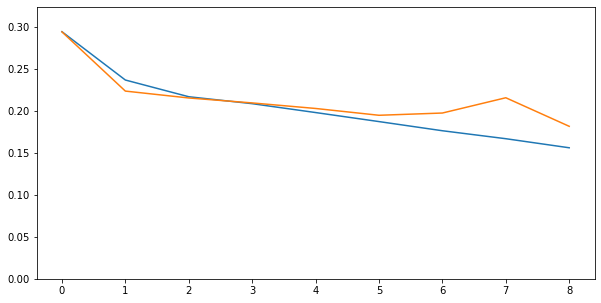

In [10]:
train_losses = trainer.GetTrainLosses()
test_losses = trainer.GetTestLosses()

plt.figure(figsize=(10, 5))

_ = plt.plot(train_losses.keys(), train_losses.values())
_ = plt.plot(test_losses.keys(), test_losses.values())

_ = plt.ylim([0, 1.1 * max(list(train_losses.values()) + list(test_losses.values()))])

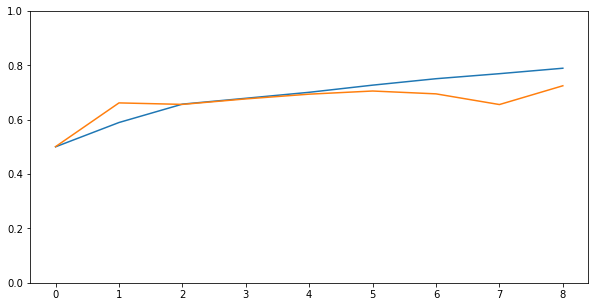

In [11]:
train_accuracies = trainer.GetTrainAccuracies()
test_accuracies = trainer.GetTestAccuracies()

plt.figure(figsize=(10, 5))

_ = plt.plot(train_accuracies.keys(), train_accuracies.values())
_ = plt.plot(test_accuracies.keys(), test_accuracies.values())

_ = plt.ylim([0, 1])

<a id='vis_test'></a>
## **Visual test**
Finally, we just test the model with a few images sampled randomly from the testing dataset (we also denormalize the tensors before plotting them, just for our visual ease sake).

In [53]:
denormalizer = tr.Compose([ 
    tr.Normalize(
        mean = [ 0., 0., 0. ], 
        std = [ 1/0.2604, 1/0.2530, 1/0.25550 ]
    ),
    tr.Normalize(
        mean = [-0.4909, -0.4555, -0.4172], 
        std = [ 1., 1., 1. ]
    ),
])

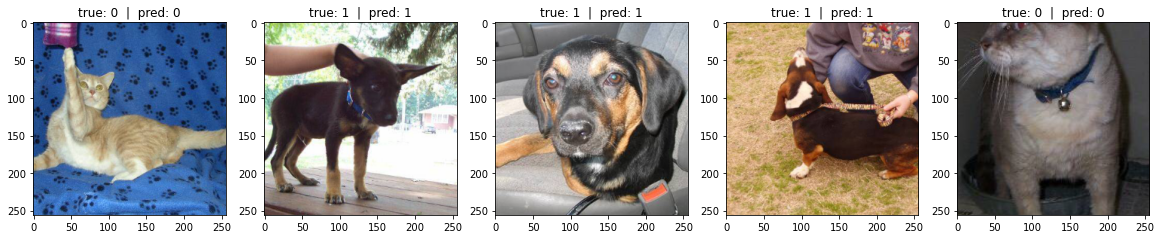

In [74]:
plt.figure(figsize=(20, 5))
for j in range(5):
    i = np.random.randint(0, len(test_dataset))

    x = torch.unsqueeze(test_dataset[i][0], dim=0).to(device)
    y = test_dataset[i][1]

    y_hat = torch.round(model(x).cpu().detach())[0]

    img = torch.round((denormalizer(x[0]) * 255)).permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)

    plt.subplot(1, 5, j+1)

    _ = plt.imshow(img)
    title = plt.title(f"true: {y[0]}  |  pred: {int(y_hat[0])}")
    
    if y[0] != y_hat[0]:
        plt.setp(title, color='r')

You can run this cell multiple times for different samples, but overall, we find it to be doing very well, guessing right for about three quarters to four fifths of the time.

THANK YOU FOR READING THROUGH OUR NOTEBOOK, HOPE YOU ENJOYED IT!